# Import Library

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from tqdm import tqdm
from copy import deepcopy

In [35]:
from graph import Graph, Point
from optimization import generate_rand_points, crossover, dominates, non_dominated_sort, crowding_distance, random_connected_partitions

# Generate Graph

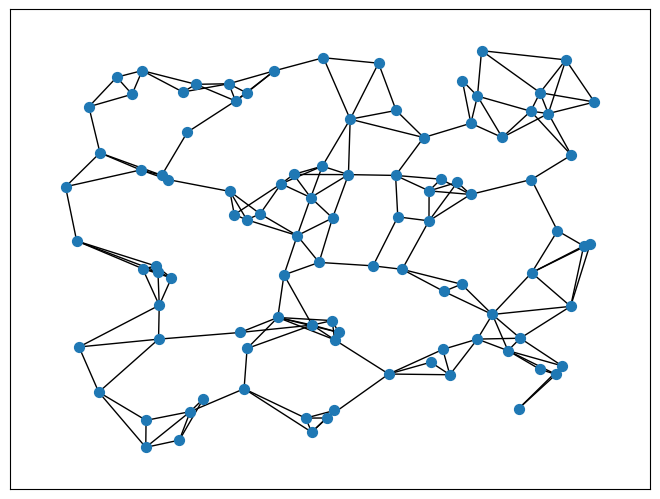

In [37]:
n_points = 100
n_partition = 5
interval = [-30, 30]

graph = generate_rand_points(Graph(), n_points, interval)
points_x, points_y = graph.get_points_coords()

weight = graph.calculate_weight(1, 2)
pos = {i: (graph.get_points()[i].get("x"), graph.get_points()[i].get("y")) for i in graph.get_points()}

G = nx.Graph(np.array(weight))
nx.draw(G, node_size=50, pos=pos)
plt.axis("on")
plt.show()

# NSGA 2

## Objective Function

In [38]:
def f1_obj(edge_cut):
    sum = 0
    for i in edge_cut: 
        sum += edge_cut.get(i, 0)
    return sum

def f2_obj(graph, n):
    sum = 0
    for i in range(n - 1):
        for j in range(i, n):
            sum += np.abs(graph.get_partition_size(i + 1) - graph.get_partition_size(j + 1)) 
    return sum

def f3_obj(graph, n):
    sum = 0
    for i in range(n):
        sum += graph.get_partition_spread(i + 1)
    return sum

In [39]:
mutation_rate = 0.6
crossover_rate = 0.5
n_iteration = 2000
n_population = 80

In [40]:
populations = np.array([])
for i in tqdm(range(n_population)):
    new_graph = deepcopy(graph) 
    random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)

for i in tqdm(range(n_iteration)):
    populations_with_offspring = np.copy(populations)

    for i in range(n_population // 2):
        a = deepcopy(populations[np.random.randint(0, n_population)])
        b = deepcopy(populations[np.random.randint(0, n_population)])
        
        populations = np.append(new_graph, populations)
        if(np.random.rand() <= crossover_rate):
            a, b = crossover(a, b, n_partition)
        if(np.random.rand() <= mutation_rate):
            a.mutate_graph()
        if(np.random.rand() <= mutation_rate):
            b.mutate_graph()
        
        populations_with_offspring = np.append(populations_with_offspring, [a, b])

    f_list = np.array([])
    for i, population in enumerate(populations_with_offspring):
        f_list = np.append(f_list, [i, f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

    f_list = f_list.reshape(n_population * 2, 4)

    fronts = non_dominated_sort(f_list)
    fronts = fronts[:len(fronts) - 1]
    crowding_distance_list = []

    for i, front in enumerate(fronts):
        crowding_distance_list.append([])
        crowding_distance_list[i] = crowding_distance(front, f_list[:, 1:])

    new_population = np.array([])

    for i, front in enumerate(fronts):
        front_temp = sorted([[front[j], crowding_distance_list[i][j]] for j in range(len(crowding_distance_list[i]))], key=lambda x: x[1], reverse=True)
        for val in front_temp:
            if(len(new_population) < n_population):
                new_population = np.append(new_population, populations_with_offspring[val[0]])
            else: 
                break
        else:
            continue
        break

    populations = np.copy(new_population)

  0%|          | 7/2000 [00:13<1:04:11,  1.93s/it]


KeyboardInterrupt: 

In [11]:
f_list = np.array([])

for i, population in enumerate(populations):
    f_list = np.append(f_list, [f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

f_list = f_list.reshape(n_population, 3)

px.scatter_3d(x=f_list[:, 0], y=f_list[:, 1], z=f_list[:, 2], opacity=0.5)